# **1. Install packages**
-------------------------------------------------------------------------

In [1]:
%%capture
!pip install catboost

# **2. Load libraries**
--------------------------------------------------------------------------------

In [2]:
# Data manipulation
#===========================================================================
import pandas as pd
import numpy as np

# Data visualization
#===========================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Preprocessing
#===========================================================================
import re
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Models
#===========================================================================
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
#===========================================================================
from sklearn.metrics import confusion_matrix, accuracy_score

# tqdm
#===========================================================================
from tqdm.auto import tqdm

# warnings
#===========================================================================
import warnings
warnings.filterwarnings('ignore')

# **3. Load data**
--------------------------------------------------------------------------------

In [3]:
data = pd.read_csv("/kaggle/input/text-classification-documentation/df_file.csv")
data.head()

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [4]:
# Dataset size
#==================================
print(f'Rows: {data.shape[0]}')
print(f'Columns: {data.shape[1]}')

Rows: 2225
Columns: 2


In [5]:
print("--------------------------------------------")
print(" " * 10,"Dataset Information")
print("--------------------------------------------")
print(data.info())

--------------------------------------------
           Dataset Information
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB
None


# **4. EDA**
------------------------------------------------------------------------------

- **Duplicated rows**

In [6]:
print(data.duplicated().sum())

98


In [7]:
# Remove duplicate rows
#===========================================================
data = data.drop_duplicates(ignore_index = True)

print(data.duplicated().sum())

0


- **Missing values**

In [8]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100.
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values

,count,%
Text,0,0.0
Label,0,0.0


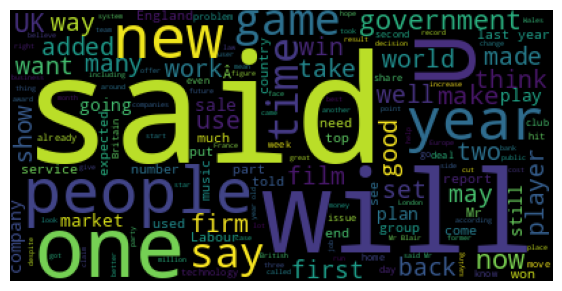

In [9]:
# WordCloud before preprocessing.
#===================================================================
all_text = " ".join(data['Text'])

wc = WordCloud(stopwords = STOPWORDS).generate(all_text)

plt.figure(figsize = (7,4))
plt.imshow(wc)
plt.axis('off')
plt.show()

-------------------------------------------------
Max Sequence before preprocessing: 4432
-------------------------------------------------


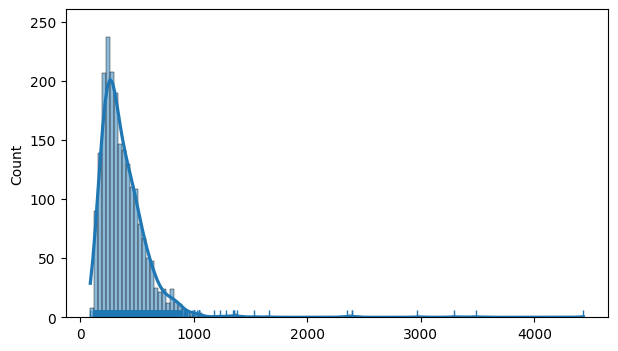

In [10]:
seq_len = []

for txt in data.Text:
    seq_len.append(len(txt.split()))
    
print('-------------------------------------------------')
print(f'Max Sequence before preprocessing: {max(seq_len)}')
print('-------------------------------------------------')
plt.figure(figsize = (7,4))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth': 2.3})
sns.rugplot(seq_len)
plt.show()

# **5. Preprocessing**
-------------------------------------------------------------------------------

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
def preprocess_text(txt:str):
    
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = txt.lower()
    txt = " ".join(txt.split())
    
    doc = nlp(txt)
    
    tokens_filtered = []
    
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
            
        tokens_filtered.append(token.lemma_)
        
    return " ".join(tokens_filtered)

In [13]:
data['prep_text'] = data['Text'].apply(preprocess_text)
data.head()

,Text,Label,prep_text
0,Budget to set scene for election\n \n Gordon B...,0,budget set scene election gordon brown seek ec...
1,Army chiefs in regiments decision\n \n Militar...,0,army chief regiment decision military chief ex...
2,Howard denies split over ID cards\n \n Michael...,0,howard deny split d card michael howard deny s...
3,Observers to monitor UK election\n \n Minister...,0,observer monitor uk election minister invite i...
4,Kilroy names election seat target\n \n Ex-chat...,0,kilroy name election seat target ex chat host ...


-------------------------------------------------
Max Sequence after preprocessing: 2013
-------------------------------------------------


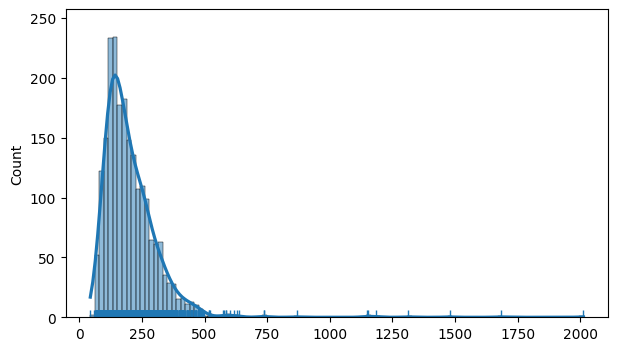

In [14]:
seq_len = []

for txt in data.prep_text:
    seq_len.append(len(txt.split()))
    
print('-------------------------------------------------')
print(f'Max Sequence after preprocessing: {max(seq_len)}')
print('-------------------------------------------------')
plt.figure(figsize = (7,4))
sns.histplot(seq_len, kde = True, line_kws = {'linewidth': 2.3})
sns.rugplot(seq_len)
plt.show()

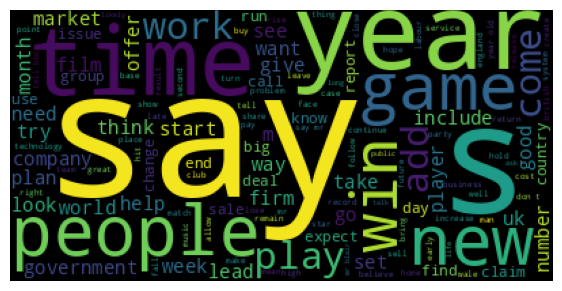

In [15]:
all_text = " ".join(data['prep_text'])

wc = WordCloud().generate(all_text)

plt.figure(figsize = (7,4))
plt.imshow(wc)
plt.axis('off')
plt.show()

We divide the data set:

- **train = 70%**
- **test = 30%**

In [16]:
X = data['prep_text']
y = data['Label']

SEED = 123

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = SEED, 
                                                    stratify = y)

print(f'X train total: {len(X_train)}')
print(f'X test total: {len(X_test)}')

X train total: 1488
X test total: 639


In [17]:
y_train.value_counts()

Label
1    353
4    352
0    282
3    258
2    243
Name: count, dtype: int64

We visualize that we have a balanced proportion in the classes, so we use **`accuracy`** as a metric.

In [18]:
# We transform our texts into numbers.
vectorizer = TfidfVectorizer()

features_train = vectorizer.fit_transform(X_train)
features_test = vectorizer.transform(X_test)

features_train = features_train.toarray()
features_test = features_test.toarray()

# **6. Model**
--------------------------------------------------------------------------------

In [19]:
# We define the candidate models.
rf = RandomForestClassifier(random_state = SEED, n_jobs = -1)
et = ExtraTreesClassifier(bootstrap = True, n_jobs = -1, random_state = SEED)
xgb = XGBClassifier(random_state = SEED, n_jobs = -1)
lgbm = LGBMClassifier(random_state = SEED, n_jobs = -1)
cb = CatBoostClassifier(random_state = SEED, verbose = 0)

MODELS = [rf, et, xgb, lgbm, cb]

In [20]:
# Training!!!

accuracy_train = {}
accuracy_test = {}

for model in tqdm(MODELS):
    name = type(model).__name__
    model.fit(features_train, y_train)
    y_pred_train = model.predict(features_train)
    accuracy_train[name] = accuracy_score(y_train, y_pred_train)
    y_pred_test = model.predict(features_test)
    accuracy_test[name] = accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished')

  0%|          | 0/5 [00:00<?, ?it/s]

* RandomForestClassifier finished
* ExtraTreesClassifier finished
* XGBClassifier finished
* LGBMClassifier finished
* CatBoostClassifier finished


# **7. Metrics**
--------------------------------------------------------------------------------

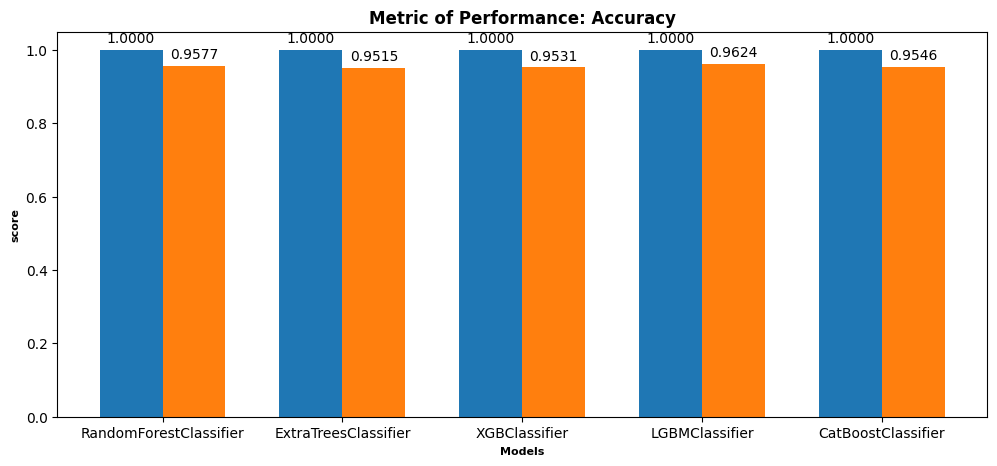

In [21]:
metric_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (12,5))
plt.style.use('ggplot')

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width)
rects2 = ax.bar(x = x + width/2, height = values_test, width = width)


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}', 
                    xy = (rect.get_x() + rect.get_width()/2, height), 
                    xytext = (0,3), 
                    textcoords = "offset points", 
                    ha = "center", 
                    va = "bottom")
        
autolabel(rects1)
autolabel(rects2)
ax.set_title("Metric of Performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

The winning model is **`LGBMClassifier`**.
We retrain the model to **`plot the confusion matrix`**.

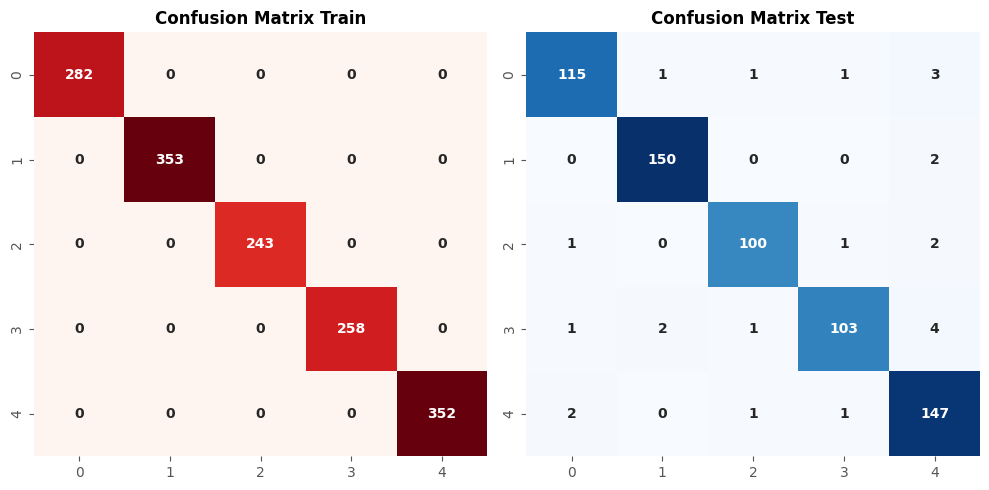

In [22]:
model = LGBMClassifier(random_state = SEED, n_jobs = -1)
model.fit(features_train, y_train)

y_pred_train = model.predict(features_train)
y_pred_test = model.predict(features_test)

cf_mx_train = confusion_matrix(y_train, y_pred_train)
cf_mx_test = confusion_matrix(y_test, y_pred_test)

fig,ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

sns.heatmap(cf_mx_train, cmap = 'Reds', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = False, ax = ax[0])

sns.heatmap(cf_mx_test, cmap = 'Blues', 
            fmt = '', annot = True, cbar = False, 
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = False, ax = ax[1])

ax[0].set_title("Confusion Matrix Train", fontsize = 12, fontweight = "bold", color = "black")
ax[1].set_title("Confusion Matrix Test", fontsize = 12, fontweight = "bold", color = "black")
fig.tight_layout()
fig.show()